In [1]:

import numpy as np
import pandas as pd
import yfinance as yf
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from typing import List, Dict


In [2]:

def fetch_multiple_stocks(symbols: List[str], start_date: str, end_date: str) -> Dict[str, pd.DataFrame]:
    data = {}
    for symbol in symbols:
        df = yf.download(symbol, start=start_date, end=end_date)
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
        df['Symbol'] = symbol
        data[symbol] = df
    return data

def add_indicators_to_all(data: Dict[str, pd.DataFrame],
                         window_sma=10, window_ema=10, window_rsi=14) -> Dict[str, pd.DataFrame]:
    for symbol, df in data.items():
        df = df.copy()
        df['SMA'] = df['Close'].rolling(window=window_sma).mean()
        df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()

        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
        rs = gain / (loss + 1e-10)
        df['RSI'] = 100 - (100 / (1 + rs))

        sma20 = df['Close'].rolling(window=20).mean()
        std20 = df['Close'].rolling(window=20).std()
        bb_upper = sma20 + 2 * std20
        bb_lower = sma20 - 2 * std20

        df['BB_Upper'] = bb_upper.values
        df['BB_Lower'] = bb_lower.values
        df['BB_Width'] = (bb_upper - bb_lower) / (sma20 + 1e-10)
        df['BB_Position'] = (df['Close'] - bb_lower) / ((bb_upper - bb_lower) + 1e-10)

        df['VolAvg'] = df['Volume'].rolling(window=5).mean()
        df['Volatility'] = df['Close'].pct_change().rolling(20).std()
        df['Ret1'] = df['Close'].pct_change(1)
        df['Ret5'] = df['Close'].pct_change(5)

        df.bfill(inplace=True)
        data[symbol] = df
    return data


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from typing import List, Dict

def fetch_multiple_stocks(symbols: List[str], start_date: str, end_date: str) -> Dict[str, pd.DataFrame]:
    """Fetch data for multiple stocks"""
    data = {}
    for symbol in symbols:
        df = yf.download(symbol, start=start_date, end=end_date)
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
        df['Symbol'] = symbol  # Add symbol column for identification
        data[symbol] = df
    return data

def add_indicators_to_all(data: Dict[str, pd.DataFrame],
                         window_sma=10, window_ema=10, window_rsi=14) -> Dict[str, pd.DataFrame]:
    """Add technical indicators to each stock's DataFrame"""
    for symbol, df in data.items():
        df = df.copy()
        # Price-based indicators
        df['SMA'] = df['Close'].rolling(window=window_sma).mean()
        df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()

        # RSI
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
        rs = gain / (loss + 1e-10)
        df['RSI'] = 100 - (100 / (1 + rs))

        # Bollinger Bands
        close = df['Close']
        sma20 = close.rolling(window=20).mean()
        std20 = close.rolling(window=20).std()
        bb_upper = sma20 + (2 * std20)
        bb_lower = sma20 - (2 * std20)

        df['BB_Upper'] = bb_upper.values
        df['BB_Lower'] = bb_lower.values
        df['BB_Width'] = (bb_upper - bb_lower) / (sma20 + 1e-10)
        df['BB_Position'] = (close - bb_lower) / ((bb_upper - bb_lower) + 1e-10)

        # Volume and volatility
        df['VolAvg'] = df['Volume'].rolling(window=5).mean()
        df['Volatility'] = df['Close'].pct_change().rolling(20).std()

        # Returns
        df['Ret1'] = df['Close'].pct_change(1)
        df['Ret5'] = df['Close'].pct_change(5)

        df.bfill(inplace=True)
        data[symbol] = df
    return data

class MultiStockTradingEnv(gym.Env):
    """Custom Gym environment for trading multiple stocks"""
    metadata = {'render.modes': ['human']}

    def __init__(self, stock_data: Dict[str, pd.DataFrame], initial_balance=10000, max_steps=200, bonus=0.1):
        super(MultiStockTradingEnv, self).__init__()

        # Verify all dataframes have same length and dates
        lengths = [len(df) for df in stock_data.values()]
        if len(set(lengths)) > 1:
            min_length = min(lengths)
            for symbol in stock_data:
                stock_data[symbol] = stock_data[symbol].iloc[:min_length]

        self.stock_data = stock_data
        self.symbols = list(stock_data.keys())
        self.num_stocks = len(self.symbols)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, min(len(df) for df in stock_data.values()) - 1)
        self.bonus = bonus

        # Actions: 0 = hold, 1 = buy stock 1, 2 = sell stock 1,
        #          3 = buy stock 2, 4 = sell stock 2, etc.
        self.action_space = spaces.Discrete(1 + 2 * self.num_stocks)

        # Observation space for each stock: [Close, SMA, EMA, RSI, Ret1, Ret5, VolAvg]
        # Plus portfolio info: [holdings for each stock, cash]
        stock_obs_low = [0, 0, 0, 0, -1, -1, 0]
        stock_obs_high = [np.inf, np.inf, np.inf, 100, 1, 1, np.inf]

        obs_low = stock_obs_low * self.num_stocks + [0] * self.num_stocks + [0]
        obs_high = stock_obs_high * self.num_stocks + [np.inf] * self.num_stocks + [np.inf]

        self.observation_space = spaces.Box(
            low=np.array(obs_low, dtype=np.float32),
            high=np.array(obs_high, dtype=np.float32),
            dtype=np.float32
        )

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = {symbol: 0 for symbol in self.symbols}
        self.current_step = 0
        self.portfolio_history = []
        return self._get_obs()

    def _get_obs(self):
        obs = []
        for symbol in self.symbols:
            row = self.stock_data[symbol].iloc[self.current_step]
            obs.extend([
                row['Close'].item(), row['SMA'].item(), row['EMA'].item(),
                row['RSI'].item(), row['Ret1'].item(), row['Ret5'].item(),
                row['VolAvg'].item()
            ])

        # Add holdings and cash
        obs.extend([float(self.shares_held[symbol]) for symbol in self.symbols])
        obs.append(float(self.balance))

        return np.array(obs, dtype=np.float32)

    def step(self, action):
        # Execute the action
        symbol_idx = (action - 1) // 2 if action > 0 else None
        if symbol_idx is not None and symbol_idx < self.num_stocks:
            symbol = self.symbols[symbol_idx]
            row = self.stock_data[symbol].iloc[self.current_step]
            price = row['Close'].item()

            if action % 2 == 1:  # Buy action
                if self.balance >= price:
                    self.shares_held[symbol] += 1
                    self.balance -= price
            else:  # Sell action
                if self.shares_held[symbol] > 0:
                    self.shares_held[symbol] -= 1
                    self.balance += price

        # Move to next time step
        self.current_step += 1
        done = self.current_step >= self.max_steps

        # Calculate new net worth
        portfolio_value = 0
        current_prices = {}
        for symbol in self.symbols:
            current_price = self.stock_data[symbol].iloc[self.current_step]['Close'].item()
            current_prices[symbol] = current_price
            portfolio_value += self.shares_held[symbol] * current_price

        prev_net_worth = self.net_worth
        self.net_worth = self.balance + portfolio_value

        # Calculate reward
        reward = self.net_worth - prev_net_worth

        # Add bonus for correct trades
        if action > 0:
            symbol = self.symbols[(action - 1) // 2]
            prev_price = self.stock_data[symbol].iloc[self.current_step - 1]['Close'].item()
            current_price = current_prices[symbol]

            if action % 2 == 1 and current_price > prev_price:  # Correct buy
                reward += self.bonus
            elif action % 2 == 0 and current_price < prev_price:  # Correct sell
                reward += self.bonus

        # Record portfolio value for metrics
        self.portfolio_history.append(self.net_worth)

        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, " +
              ", ".join([f"{symbol}: {shares}" for symbol, shares in self.shares_held.items()]) +
              f", Net Worth: {self.net_worth:.2f}")

    def calculate_metrics(self):
        """Calculate performance metrics like Sharpe ratio"""
        if len(self.portfolio_history) < 2:
            return {}

        returns = np.diff(self.portfolio_history) / self.portfolio_history[:-1]

        metrics = {
            'final_value': self.portfolio_history[-1],
            'total_return': (self.portfolio_history[-1] - self.initial_balance) / self.initial_balance,
            'sharpe_ratio': np.sqrt(252) * np.mean(returns) / (np.std(returns) + 1e-10),
            'max_drawdown': (np.maximum.accumulate(self.portfolio_history) - self.portfolio_history).max() /
                            np.maximum.accumulate(self.portfolio_history).max(),
            'volatility': np.std(returns) * np.sqrt(252)
        }
        return metrics

In [4]:
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
def train_dqn(env, num_episodes=500, batch_size=64, gamma=0.99,
              epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=2000,
              target_update_freq=10, learning_rate=1e-3):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize networks
    policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = ReplayBuffer(10000)
    steps_done = 0
    episode_rewards = []

    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.randrange(env.action_space.n)
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            return policy_net(state_tensor).argmax().item()

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)

        for t in range(env.max_steps):
            action = select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.push(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps_done += 1

            # Train on batch if enough samples
            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))

                # Convert to tensors with float32 dtype
                non_final_mask = torch.tensor(tuple(map(lambda s: not s, batch.done)),
                                          dtype=torch.bool).to(device)
                non_final_next_states = torch.tensor([s for s, d in zip(batch.next_state, batch.done) if not d],
                                                   dtype=torch.float32).to(device)

                state_batch = torch.tensor(batch.state, dtype=torch.float32).to(device)
                action_batch = torch.tensor(batch.action, dtype=torch.long).unsqueeze(1).to(device)
                reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)

                # Current Q values
                current_q = policy_net(state_batch).gather(1, action_batch)

                # Next Q values
                next_q = torch.zeros(batch_size, dtype=torch.float32).to(device)
                with torch.no_grad():
                    next_q[non_final_mask] = target_net(non_final_next_states).max(1)[0]
                expected_q = reward_batch + gamma * next_q.unsqueeze(1)

                # Compute loss and optimize
                loss = nn.MSELoss()(current_q, expected_q)
                optimizer.zero_grad()
                loss.backward()

                # Clip gradients to prevent explosion
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()

            if done:
                break

        # Update target network
        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        episode_rewards.append(total_reward)
        print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

    return policy_net, episode_rewards

In [9]:
def evaluate_policy(env, policy_net, device='cpu'):
    state = env.reset()
    done = False
    portfolio_values = []

    while not done:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action = policy_net(state_tensor).argmax().item()

        state, _, done, _ = env.step(action)
        portfolio_values.append(env.net_worth)

    metrics = env.calculate_metrics()
    return portfolio_values, metrics

def plot_results(train_values, test_values, train_metrics, test_metrics, symbols):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Training results
    ax1.plot(train_values, label='DQN Agent')
    for symbol in symbols:
        prices = train_data[symbol]['Close'].iloc[:len(train_values)].values
        bh_values = prices / prices[0] * env.initial_balance
        ax1.plot(bh_values, label=f'{symbol} Buy & Hold')

    ax1.set_title(f'Training Performance\nSharpe: {train_metrics["sharpe_ratio"]:.2f}, ' +
                  f'Return: {train_metrics["total_return"]*100:.1f}%')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Portfolio Value')
    ax1.legend()

    # Test results
    ax2.plot(test_values, label='DQN Agent')
    for symbol in symbols:
        prices = test_data[symbol]['Close'].iloc[:len(test_values)].values
        bh_values = prices / prices[0] * env_test.initial_balance
        ax2.plot(bh_values, label=f'{symbol} Buy & Hold')

    ax2.set_title(f'Test Performance\nSharpe: {test_metrics["sharpe_ratio"]:.2f}, ' +
                  f'Return: {test_metrics["total_return"]*100:.1f}%')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Portfolio Value')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [16]:

symbols = ['AAPL', 'GOOGL', 'MSFT'] # Example stocks
train_start = '2020-01-01'
train_end = '2021-01-01'
test_start = '2021-01-02'
test_end = '2023-01-01'
symbol_test = ['AAPL', 'GOOGL', 'MSFT']
# Fetch and prepare data
train_data = fetch_multiple_stocks(symbols, train_start, train_end)
train_data = add_indicators_to_all(train_data)

test_data = fetch_multiple_stocks(symbol_test, test_start, test_end)
test_data = add_indicators_to_all(test_data)

# Create environments
env = MultiStockTradingEnv(train_data, initial_balance=10000, max_steps=200, bonus=0.1)
env_test = MultiStockTradingEnv(test_data, initial_balance=10000, max_steps=200, bonus=0.1)

# Train the agent
policy_net, episode_rewards = train_dqn(env)





/tmp/ipython-input-3-686827271.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-686827271.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-686827271.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-686827271.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-686

Episode 1/500, Total Reward: 249.30, Epsilon: 1.00
Episode 2/500, Total Reward: 241.56, Epsilon: 0.91
Episode 3/500, Total Reward: 392.20, Epsilon: 0.83
Episode 4/500, Total Reward: 464.23, Epsilon: 0.75
Episode 5/500, Total Reward: 378.39, Epsilon: 0.69
Episode 6/500, Total Reward: 872.38, Epsilon: 0.63
Episode 7/500, Total Reward: 638.08, Epsilon: 0.57
Episode 8/500, Total Reward: 1643.34, Epsilon: 0.52
Episode 9/500, Total Reward: 1079.16, Epsilon: 0.48
Episode 10/500, Total Reward: 908.11, Epsilon: 0.44
Episode 11/500, Total Reward: 627.07, Epsilon: 0.40
Episode 12/500, Total Reward: 994.14, Epsilon: 0.37
Episode 13/500, Total Reward: 532.17, Epsilon: 0.34
Episode 14/500, Total Reward: 817.54, Epsilon: 0.31
Episode 15/500, Total Reward: 1110.66, Epsilon: 0.28
Episode 16/500, Total Reward: 396.49, Epsilon: 0.26
Episode 17/500, Total Reward: 374.91, Epsilon: 0.24
Episode 18/500, Total Reward: 1541.78, Epsilon: 0.22
Episode 19/500, Total Reward: 599.77, Epsilon: 0.21
Episode 20/500, T

In [17]:
# Evaluate on training data
train_values, train_metrics = evaluate_policy(env, policy_net)
print("\nTraining Metrics:")
for k, v in train_metrics.items():
        print(f"{k}: {v:.4f}")

# Evaluate on test data
test_values, test_metrics = evaluate_policy(env_test, policy_net)
print("\nTest Metrics:")
for k, v in test_metrics.items():
        print(f"{k}: {v:.4f}")



Training Metrics:
final_value: 12158.3609
total_return: 0.2158
sharpe_ratio: 1.6004
max_drawdown: 0.1078
volatility: 0.1631

Test Metrics:
final_value: 11839.6561
total_return: 0.1840
sharpe_ratio: 1.4717
max_drawdown: 0.0916
volatility: 0.1532


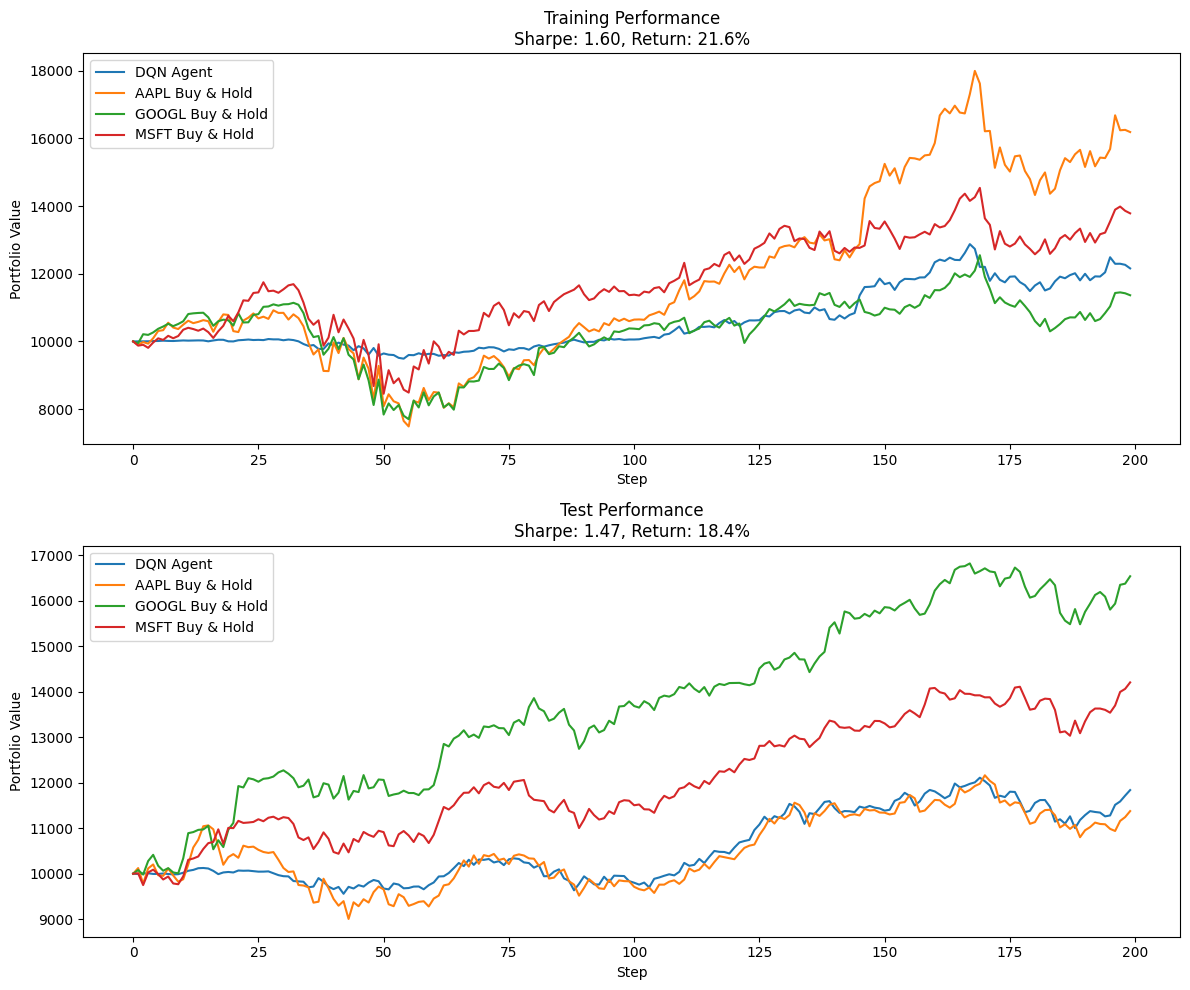

In [18]:
# Plot results
plot_results(train_values, test_values, train_metrics, test_metrics, symbols)